In [65]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines


In [66]:
# Load the dataset
data_path = './datasets/regression_data_uni_group_12_train.txt'

# Adjusting the data loading process to skip the header row
data = np.loadtxt(data_path, skiprows=1)
np.random.seed(42)  # For reproducibility
np.random.shuffle(data)  # Randomly shuffle the data

# Separate features and targets again
X = data[:, :5]  # Features (sensor readings)
y = data[:, 5:]  # Targets (y position)

split_idx1 = int(X.shape[0] * 0.8)
split_idx2 = split_idx1 + int((X.shape[0] - split_idx1) * 0.5)

X_train = X[:split_idx1]
X_val = X[split_idx1:split_idx2]
X_test = X[split_idx2:]
y_train = y[:split_idx1]
y_val = y[split_idx1:split_idx2]
y_test = y[split_idx2:]

mean_X = np.mean(X_train, axis=0)
std_dev_X = np.std(X_train, axis=0)
norm2_X = np.linalg.norm(X_train, axis=0)

mean_y = np.mean(y_train, axis=0)
std_dev_y = np.std(y_train, axis=0)
norm2_y = np.linalg.norm(y_train, axis=0)

X_train_norm_2 = X_train / norm2_X
y_train_norm_2 = y_train / norm2_y

X_val_norm_2 = X_val / norm2_X
y_val_norm_2 = y_val / norm2_y

X_test_norm_2 = X_test / norm2_X
y_test_norm_2 = y_test / norm2_y

X_train_norm_zs = (X_train - mean_X) / std_dev_X
y_train_norm_zs = (y_train - mean_y) / std_dev_y

X_val_norm_zs = (X_val - mean_X) / std_dev_X
y_val_norm_zs = (y_val - mean_y) / std_dev_y

X_test_norm_zs = (X_test - mean_X) / std_dev_X
y_test_norm_zs = (y_test - mean_y) / std_dev_y


def phi_x(X):
    return np.c_[X, np.ones((X.shape[0], 1))]

def identity(X):
    return X

def sigmoid(X):
    return 1 / (1 + np.exp(-X))

def gaussian(X, meu=0, sigma=1):
    return 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((X-meu)/sigma)**2)

def laplacian(X, meu=0, sigma=1):
    return 1 / (2 * sigma) * np.exp(-(np.absolute(X-meu)/sigma)) 

def tanh_0_1(X):
    return (1 + np.tanh(X)) / 2


In [67]:
def get_theta(X, y, f):
    # Add a bias term (column of ones) to X for the intercept
    phi_X = phi_x(f(X))

    # Solve the normal equation again: theta = (X_b.T * X_b)^(-1) * X_b.T * y
    theta = np.linalg.inv(phi_X.T.dot(phi_X)).dot(phi_X.T).dot(y)

    return theta

In [68]:
def print_poly(theta, f_name, norm=""):
    m, n = theta.shape
    norm = "_" + norm if norm != "" else ""
    for i in range(n):
        poly = ""
        for j in range(m):
            poly += f"{theta[j][i]:.4f}*{f_name}(X{j+1}{norm}) + "
        print(poly + f"{theta[j][i]:.4f} = y{norm}'")

In [69]:
# Calculating the Pearson Correlation, MSE, and MAE using only numpy

# Function to calculate Pearson Correlation Coefficient
def pearson_correlation(actual, predicted):
    numerator = np.sum((actual - np.mean(actual)) *
                       (predicted - np.mean(predicted)))
    denominator = np.sqrt(np.sum((actual - np.mean(actual))**2)
                          * np.sum((predicted - np.mean(predicted))**2))
    return numerator / denominator

# Function to calculate Mean Squared Error


def root_mean_squared_error(actual, predicted):
    return np.sqrt(np.mean((actual - predicted) ** 2))

# Function to calculate Mean Absolute Error


def mean_absolute_error(actual, predicted):
    return np.mean(np.abs(actual - predicted))


def get_metrics(y, y_pred):

    # Calculating Pearson Correlation for each target
    pearson_corr = np.array([pearson_correlation(
        y[:, i], y_pred[:, i]) for i in range(y.shape[1])])

    # Calculating MSE and MAE for each target
    rmse = np.array([root_mean_squared_error(y[:, i], y_pred[:, i])
                    for i in range(y.shape[1])])
    mae = np.array([mean_absolute_error(y[:, i], y_pred[:, i])
                    for i in range(y.shape[1])])

    return pearson_corr, rmse, mae

In [70]:
lookup_table_refined = {
    0.05: 1.960,  # Critical value for p = 0.05
    0.01: 2.576,  # Critical value for p = 0.01
    0.001: 3.291  # Critical value for p = 0.001
}

In [71]:
def plot_y(X, y, theta, f, norm=""):
   # Adjusting the correlation plots to include the best fit line and y=x line

    X_b = phi_x(f(X))
    y_pred = np.matmul(X_b, theta)

    pc, rmse, mae = get_metrics(y, y_pred)

    plt.figure(figsize=(10, 15))

    for i in range(y.shape[1]):
        # Scatter plot for actual vs predicted
        plt.subplot(3, 1, i+1)
        plt.scatter(y[:, i], y_pred[:, i], alpha=0.5,
                    color='green', marker='x')

        # Best fit line (red line)
        m, b = np.polyfit(y[:, i], y_pred[:, i], 1)  # m = slope, b = intercept
        plt.plot(y[:, i], m * y[:, i] + b, 'r--', label='Best Fit Line')

        # y=x line (black dotted line)
        plt.plot(y[:, i], y[:, i], 'k--', label='y=x Line')

        # Calculate Standard Error
        errors = y[:, i] - y_pred[:, i]
        s_sq = errors.T @ errors / (X.shape[0] - len(theta) - 1)
        SE_Theta = np.sqrt(np.diag(np.linalg.inv(X.T @ X) * s_sq))

        # Step 3: Calculate t-Statistic for each coefficient
        t_stats = theta[:, i].flatten()[:-1] / SE_Theta

        # Determine the p-value approximation based on the refined critical values
        # Default if t-statistic is below the lowest threshold
        p_value = ["p>0.05"]*len(t_stats)
        for j, t in enumerate(t_stats):
            for p, t_crit in lookup_table_refined.items():
                if abs(t) > t_crit:
                    p_value[j] = f"p<{p}"

        print(p_value)

        # Creating custom legend handles
        pc_handle = mlines.Line2D([], [], color='none', marker='None',
                                  label=f'r={pc[i]:.4f}')
        rmse_handle = mlines.Line2D([], [], color='none', marker='None',
                                    label=f'rmse={rmse[i]:.4f}')
        mae_handle = mlines.Line2D([], [], color='none', marker='None',
                                   label=f'mae={mae[i]:.4f}')

        # Adding custom legend handles to the existing legend handles
        handles, labels = plt.gca().get_legend_handles_labels()
        handles.extend([pc_handle, rmse_handle, mae_handle])

        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title(f'Correlation Plot for y {norm}')

        # Creating the legend with the custom handles
        plt.legend(handles=handles)

    plt.tight_layout()
    plt.show()

In [72]:
def h(X, f):
    return phi_x(f(X))


def L(a, b):
    return np.square(np.linalg.norm(a - b))


def R(X, y, theta):
    return 1/(2*y.shape[0]) * np.sum(L(np.matmul(X, theta), y))


def dR_dtheta(X, y, theta):
    return 1/(y.shape[0]) * np.matmul(X.T, (np.matmul(X, theta)) - y)


def grad_desc_sq_err(X, y, X_, y_, f, lr=0.1, epochs=10000, eps=0.05):
    train_losses = []
    val_losses = []
    h_X = h(X, f)
    h_X_ = h(X_, f)
    theta = np.random.rand(h_X.shape[1], y.shape[1])
    for i in range(epochs):
        train_losses.append(R(h_X, y, theta))
        grad_theta = dR_dtheta(h_X, y, theta)
        if np.linalg.norm(grad_theta) < eps:
            break
        theta -= lr * grad_theta

        val_losses.append(R(h_X_, y_, theta))
        if (i) % 50 == 0:
            print(
                f"Emprical Risk(Training) at epoch {i+1}: {train_losses[-1]} | Emprical Risk(Validation) at epoch {i+1}: {val_losses[-1]}")

    print(
        f"Emprical Risk(Training) at epoch {i+1}: {train_losses[-1]} |  Emprical Risk(Validation) at epoch {i+1}: {val_losses[-1]}")
    return theta, np.array(train_losses), np.array(val_losses)


def plot_train_loss(tl, vl):
    # Plotting the Risk history to see the convergence
    plt.plot(tl, label='Emprical Risk(Training)')
    plt.plot(vl, label='Emprical Risk(Validation)')
    plt.xlabel('Iteration')
    plt.ylabel('Risk')
    plt.title('Risk Function History')
    plt.legend()
    plt.show()

-9.6781*Sig(X1) + 12.4232*Sig(X2) + 0.3072*Sig(X3) + -1.2951*Sig(X4) + -0.6749*Sig(X5) + 0.0033*Sig(X6) + 0.0033 = y'
['p<0.001', 'p<0.001', 'p<0.001', 'p<0.001', 'p<0.001']


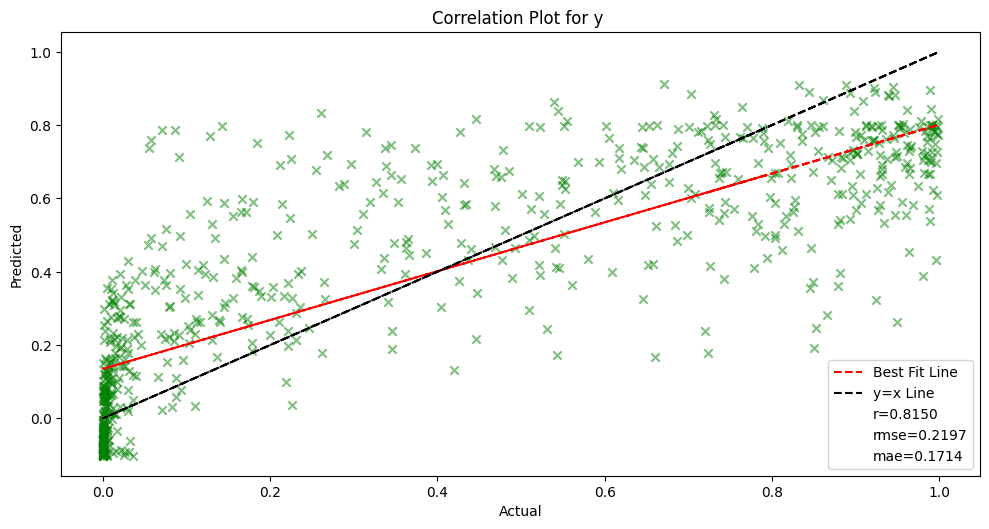

3.8535*Gauss(X1) + -6.3875*Gauss(X2) + 0.2970*Gauss(X3) + 2.9993*Gauss(X4) + 1.1574*Gauss(X5) + -0.0853*Gauss(X6) + -0.0853 = y'
['p<0.001', 'p<0.001', 'p<0.001', 'p<0.001', 'p<0.001']


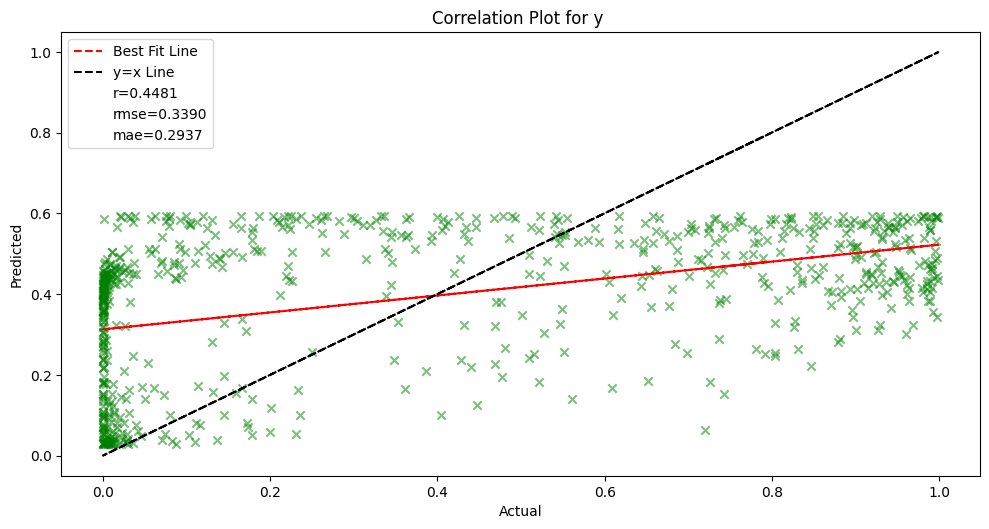

-41.9935*Lap(X1) + 41.0046*Lap(X2) + -0.1874*Lap(X3) + -10.3813*Lap(X4) + 0.4122*Lap(X5) + 2.4039*Lap(X6) + 2.4039 = y'
['p<0.001', 'p<0.001', 'p<0.001', 'p<0.001', 'p<0.001']


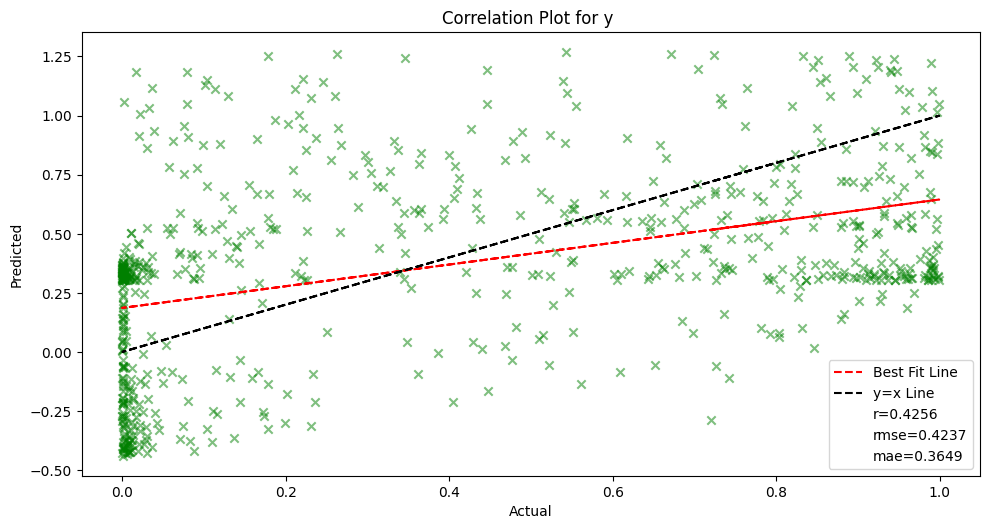

-13.1296*tanh(X1) + 15.1281*tanh(X2) + 0.0912*tanh(X3) + -0.7458*tanh(X4) + -0.4304*tanh(X5) + 0.0852*tanh(X6) + 0.0852 = y'
['p<0.001', 'p<0.001', 'p<0.01', 'p<0.001', 'p<0.001']


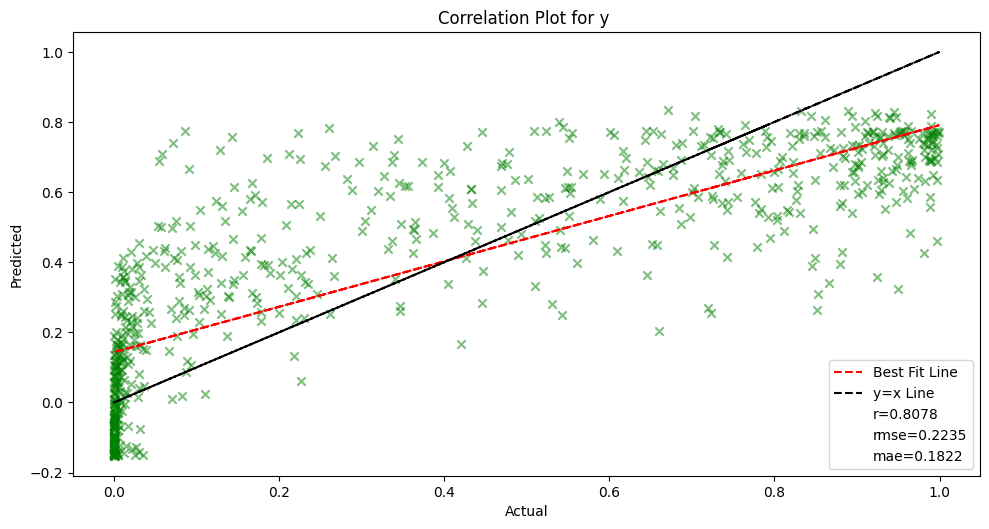

3.8535*Id(X1) + -6.3875*Id(X2) + 0.2970*Id(X3) + 2.9993*Id(X4) + 1.1574*Id(X5) + -0.0853*Id(X6) + -0.0853 = y'
['p<0.001', 'p<0.001', 'p<0.001', 'p<0.001', 'p<0.001']


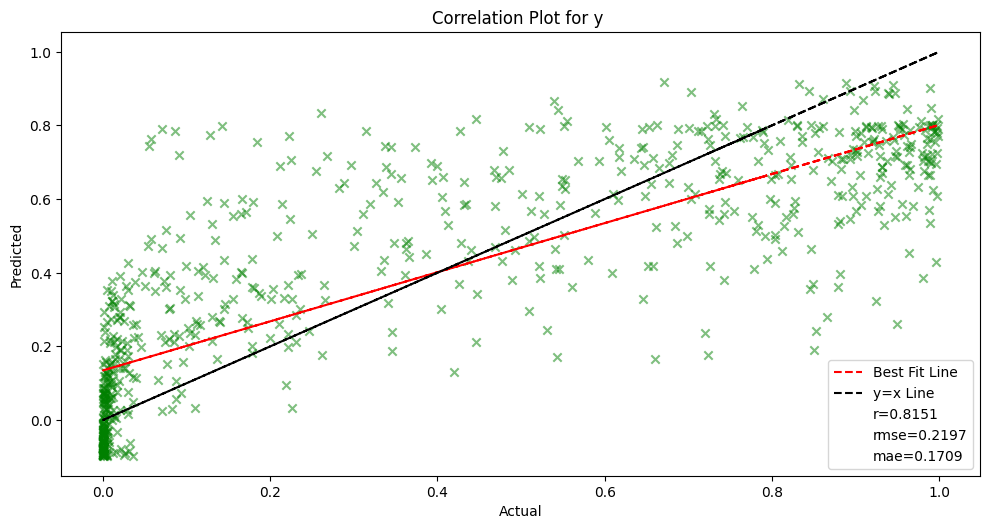

In [73]:
theta_sigmoid = get_theta(X, y, sigmoid)
print_poly(theta_sigmoid, "Sig")
plot_y(X_test, y_test, theta_sigmoid, sigmoid)

theta_gaussian = get_theta(X, y, gaussian)
print_poly(theta_gaussian, "Gauss")
plot_y(X_test, y_test, theta_gaussian, gaussian)

theta_laplacian = get_theta(X, y, laplacian)
print_poly(theta_laplacian, "Lap")
plot_y(X_test, y_test, theta_gaussian, laplacian)

theta_tanh_0_1 = get_theta(X, y, tanh_0_1)
print_poly(theta_tanh_0_1, "tanh")
plot_y(X_test, y_test, theta_tanh_0_1, tanh_0_1)

theta_identity = get_theta(X, y, identity)
print_poly(theta_gaussian, "Id")
plot_y(X_test, y_test, theta_identity, identity)

In [74]:
# theta_sigmoid_norm_zs = get_theta(X_train_norm_zs, y_train_norm_zs, sigmoid)
# print_poly(theta_sigmoid_norm_zs, "Sig", "norm_zs")
# plot_y(X_test_norm_zs, y_test_norm_zs, theta_sigmoid_norm_zs, sigmoid, "norm_zs")

# theta_gaussian_norm_zs = get_theta(X_train_norm_zs, y_train_norm_zs, gaussian)
# print_poly(theta_gaussian_norm_zs, "Gauss", "norm_zs")
# plot_y(X_test_norm_zs, y_test_norm_zs, theta_gaussian_norm_zs, gaussian)

# theta_laplacian_norm_zs = get_theta(
#     X_train_norm_zs, y_train_norm_zs, laplacian)
# print_poly(theta_laplacian_norm_zs, "Lap", "norm_zs")
# plot_y(X_test_norm_zs, y_test_norm_zs, theta_laplacian_norm_zs, laplacian)

# theta_tanh_0_1_norm_zs = get_theta(X_train_norm_zs, y_train_norm_zs, tanh_0_1)
# print_poly(theta_tanh_0_1_norm_zs, "tanh", "norm_zs")
# plot_y(X_test_norm_zs, y_test_norm_zs, theta_tanh_0_1_norm_zs, tanh_0_1)

# theta_identity_norm_zs = get_theta(X_train_norm_zs, y_train_norm_zs, identity)
# print_poly(theta_identity_norm_zs, "Id", "norm_zs")
# plot_y(X_test_norm_zs, y_test_norm_zs,
#        theta_identity_norm_zs, identity, "norm_zs")

In [75]:
# theta_sigmoid_norm_2 = get_theta(X_train_norm_2, y_train_norm_2, sigmoid)
# print_poly(theta_sigmoid_norm_2, "Sig", "norm_zs")
# plot_y(X_test_norm_2, y_test_norm_2, theta_sigmoid_norm_2, sigmoid, "norm_2")


# theta_gaussian_norm_2 = get_theta(X_train_norm_2, y_train_norm_2, gaussian)
# print_poly(theta_gaussian_norm_2, "Gauss")
# plot_y(X_test_norm_2, y_test_norm_2, theta_gaussian_norm_2, gaussian, "norm_2")

# theta_laplacian_norm_2 = get_theta(X_train_norm_2, y_train_norm_2, laplacian)
# print_poly(theta_laplacian_norm_2, "Lap")
# plot_y(X_test_norm_2, y_test_norm_2,
#        theta_laplacian_norm_2, laplacian, "norm_2")

# theta_tanh_0_1_norm_2 = get_theta(X_train_norm_2, y_train_norm_2, tanh_0_1)
# print_poly(theta_tanh_0_1_norm_2, "tanh")
# plot_y(X_test_norm_2, y_test_norm_2, theta_tanh_0_1_norm_2, tanh_0_1, "norm_2")

# theta_identity_norm_2 = get_theta(X_train_norm_2, y_train_norm_2, identity)
# print_poly(theta_identity_norm_2, "Id", "norm_2")
# plot_y(X_test_norm_2, y_test_norm_2, theta_identity_norm_2, identity, "norm_2")

Emprical Risk(Training) at epoch 1: 0.7880402739261217 | Emprical Risk(Validation) at epoch 1: 0.47380271837894417
Emprical Risk(Training) at epoch 51: 0.07735200636082451 | Emprical Risk(Validation) at epoch 51: 0.08219744908542966
Emprical Risk(Training) at epoch 62: 0.07452812923391416 |  Emprical Risk(Validation) at epoch 62: 0.07944141083118168


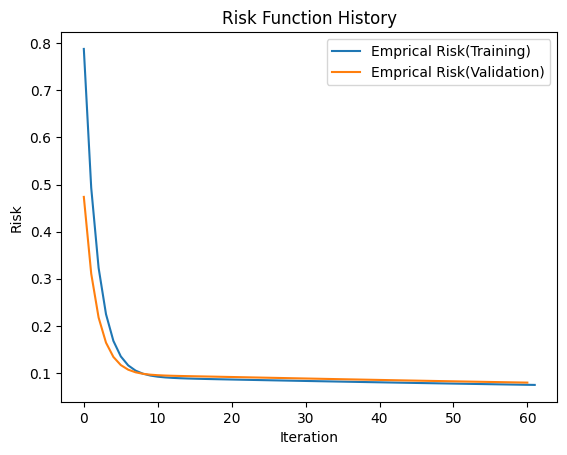

0.5444*Sig(X1) + -0.0482*Sig(X2) + 0.0829*Sig(X3) + 0.0415*Sig(X4) + 0.2278*Sig(X5) + -0.0354*Sig(X6) + -0.0354 = y'
['p>0.05', 'p>0.05', 'p>0.05', 'p<0.05', 'p<0.001']


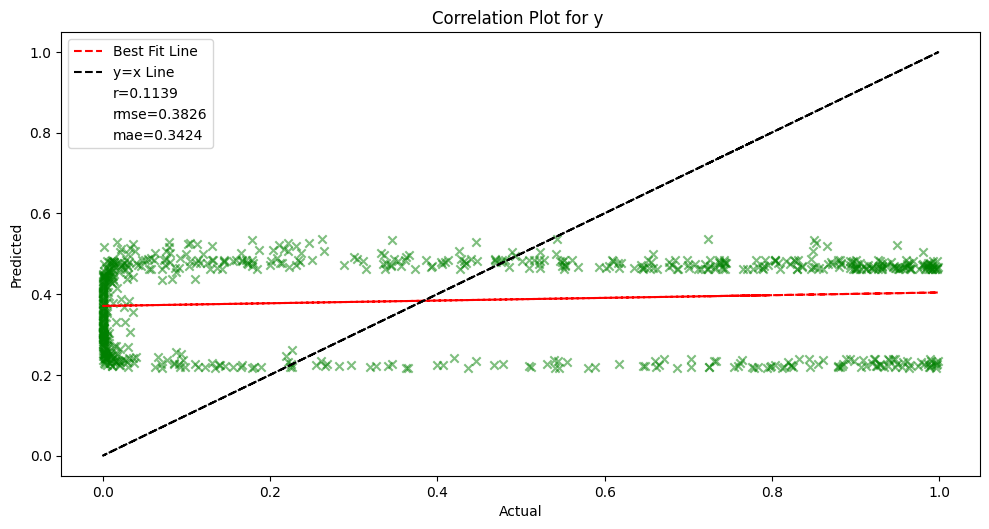

In [76]:
theta_gd_sig, train_losses, val_losses = grad_desc_sq_err(
    X_train, y_train, X_val, y_val, sigmoid)
plot_train_loss(train_losses, val_losses)
print_poly(theta_gd_sig, "Sig")
plot_y(X_test, y_test, theta_gd_sig, sigmoid)

# theta_gd_sig_norm_2, train_losses, val_losses = grad_desc_sq_err(
#     X_train_norm_2, y_train_norm_2, X_val_norm_2, y_val_norm_2, sigmoid)
# plot_train_loss(train_losses, val_losses)
# print_poly(theta_gd_sig_norm_2, "Sig", "norm_2")
# plot_y(X_test_norm_2, y_test_norm_2, theta_gd_sig_norm_2, sigmoid, "norm_2")

# theta_gd_sig_norm_zs, train_losses, val_losses = grad_desc_sq_err(
#     X_train_norm_zs, y_train_norm_zs, X_val_norm_zs, y_val_norm_zs, sigmoid)
# plot_train_loss(train_losses, val_losses)
# print_poly(theta_gd_sig_norm_zs, "Sig", "norm_zs")
# plot_y(X_test_norm_zs, y_test_norm_zs, theta_gd_sig_norm_2, sigmoid, "norm_zs")

Emprical Risk(Training) at epoch 1: 0.6408679143260588 | Emprical Risk(Validation) at epoch 1: 0.47276767526726426
Emprical Risk(Training) at epoch 22: 0.0713204995140959 |  Emprical Risk(Validation) at epoch 22: 0.07411827868567508


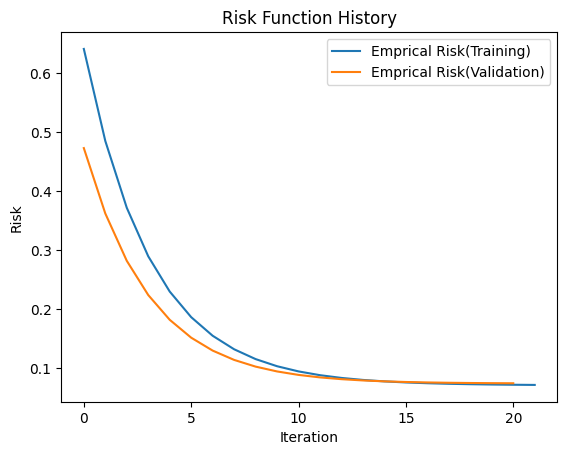

0.0528*G(X1) + 0.3207*G(X2) + 0.1282*G(X3) + 0.7332*G(X4) + 0.7050*G(X5) + -0.1888*G(X6) + -0.1888 = y'
['p>0.05', 'p>0.05', 'p<0.01', 'p<0.001', 'p<0.001']


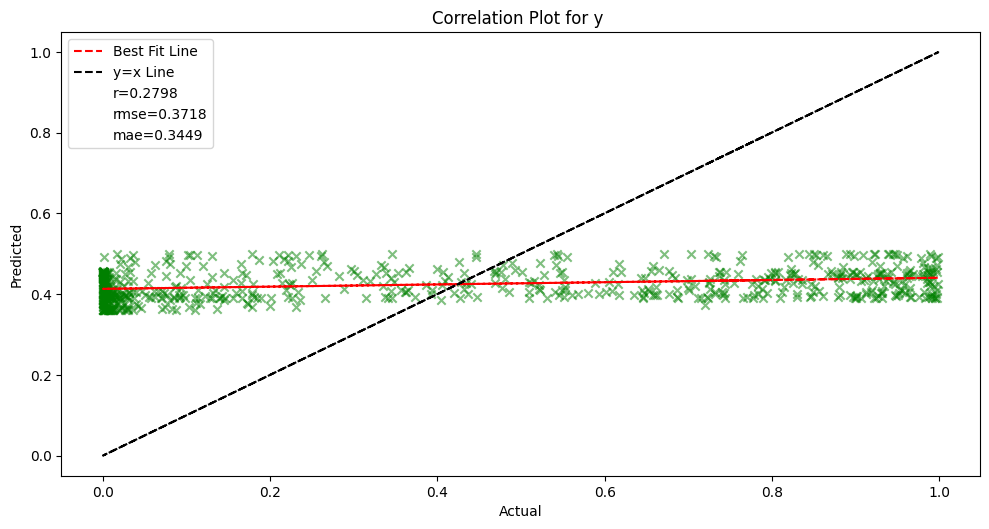

In [77]:
theta_gd_gauss, train_losses, val_losses = grad_desc_sq_err(
    X_train, y_train, X_val, y_val, gaussian)
plot_train_loss(train_losses, val_losses)
print_poly(theta_gd_gauss, "G")
plot_y(X_test, y_test, theta_gd_gauss, gaussian)

# theta_gd_gauss_norm_2, train_losses, val_losses = grad_desc_sq_err(
#     X_train_norm_2, y_train_norm_2, X_val_norm_2, y_val_norm_2, gaussian)
# print_poly(theta_gd_gauss_norm_2, "G", "norm_2")
# plot_train_loss(train_losses, val_losses)
# plot_y(X_test_norm_2, y_test_norm_2, theta_gd_gauss_norm_2, gaussian, "norm_2")

# theta_gd_gauss_norm_zs, train_losses, val_losses = grad_desc_sq_err(
#     X_train_norm_zs, y_train_norm_zs, X_val_norm_zs, y_val_norm_zs, gaussian)
# plot_train_loss(train_losses, val_losses)
# print_poly(theta_gd_gauss_norm_zs, "G", "norm_zs")
# plot_y(X_test_norm_zs, y_test_norm_zs, theta_gd_gauss_norm_zs, gaussian, "norm_zs")

Emprical Risk(Training) at epoch 1: 0.6481901675411312 | Emprical Risk(Validation) at epoch 1: 0.4862135749845769
Emprical Risk(Training) at epoch 25: 0.079871108319863 |  Emprical Risk(Validation) at epoch 25: 0.08259363731657211


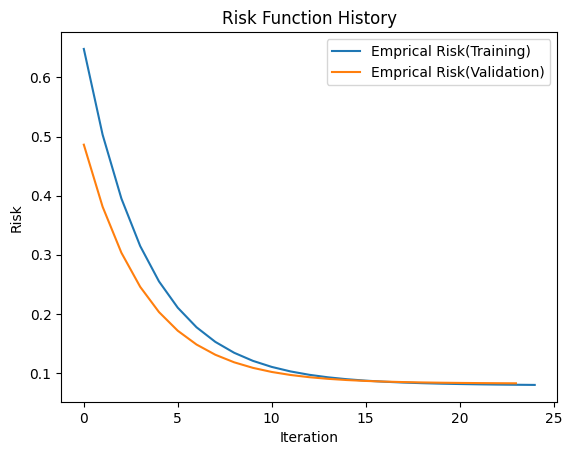

0.0815*L(X1) + 0.4822*L(X2) + -0.1733*L(X3) + 0.3073*L(X4) + 0.1336*L(X5) + 0.1828*L(X6) + 0.1828 = y'
['p>0.05', 'p>0.05', 'p<0.001', 'p<0.001', 'p<0.001']


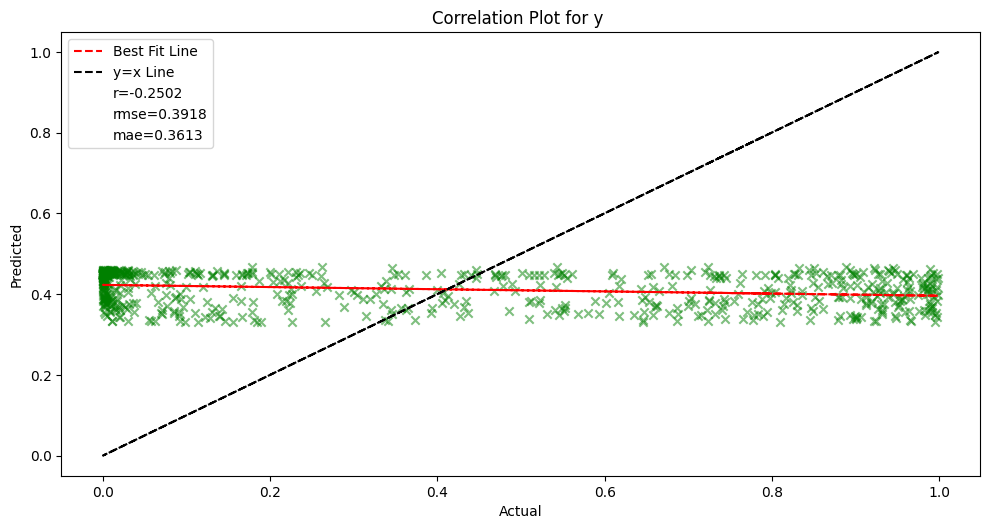

In [78]:
theta_gd_lap, train_losses, val_losses = grad_desc_sq_err(
    X_train, y_train, X_val, y_val, laplacian)
plot_train_loss(train_losses, val_losses)
print_poly(theta_gd_lap, "L")
plot_y(X_test, y_test, theta_gd_lap, laplacian)

# theta_gd_lap_norm_2, train_losses, val_losses = grad_desc_sq_err(
#     X_train_norm_2, y_train_norm_2, X_val_norm_2, y_val_norm_2, laplacian)
# print_poly(theta_gd_lap_norm_2, "L", "norm_2")
# plot_train_loss(train_losses, val_losses)
# plot_y(X_test_norm_2, y_test_norm_2, theta_gd_lap_norm_2, laplacian, "norm_2")

# theta_gd_lap_norm_zs, train_losses, val_losses = grad_desc_sq_err(
#     X_train_norm_zs, y_train_norm_zs, X_val_norm_zs, y_val_norm_zs, laplacian)
# plot_train_loss(train_losses, val_losses)
# print_poly(theta_gd_lap_norm_zs, "L", "norm_zs")
# plot_y(X_test_norm_zs, y_test_norm_zs, theta_gd_lap_norm_zs, laplacian, "norm_zs")

Emprical Risk(Training) at epoch 1: 1.4245360967328753 | Emprical Risk(Validation) at epoch 1: 0.7662447999371029
Emprical Risk(Training) at epoch 36: 0.04017369859488497 |  Emprical Risk(Validation) at epoch 36: 0.03955233892443365


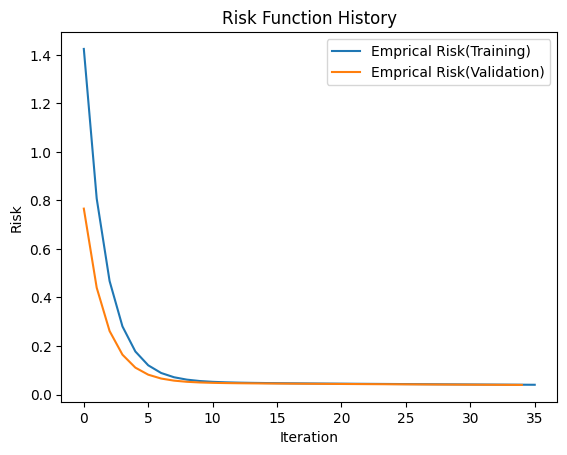

-0.2188*tanh(X1) + 0.3137*tanh(X2) + 0.4746*tanh(X3) + -0.0808*tanh(X4) + -0.2990*tanh(X5) + 0.2939*tanh(X6) + 0.2939 = y'
['p>0.05', 'p>0.05', 'p<0.001', 'p<0.001', 'p<0.001']


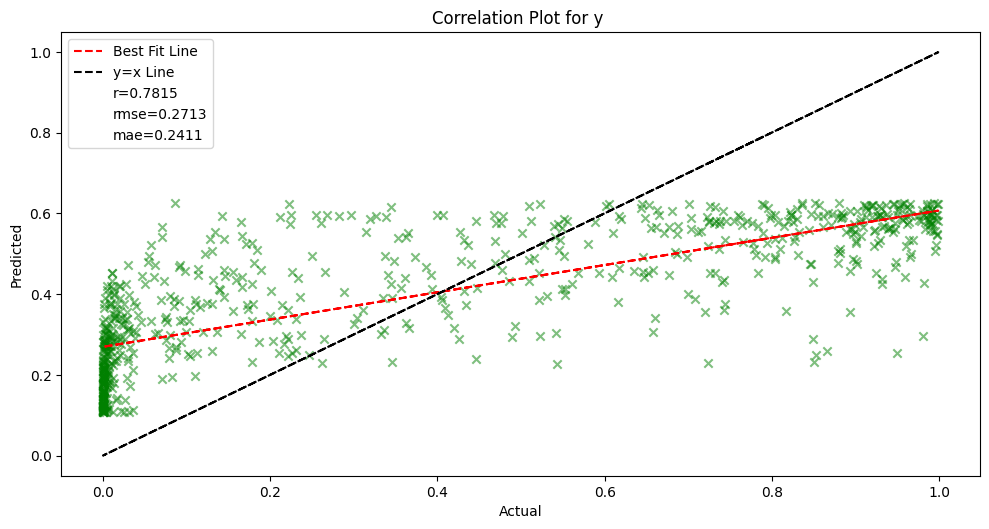

In [79]:
theta_gd_tanh, train_losses, val_losses = grad_desc_sq_err(
    X_train, y_train, X_val, y_val, tanh_0_1)
plot_train_loss(train_losses, val_losses)
print_poly(theta_gd_tanh, "tanh")
plot_y(X_test, y_test, theta_gd_tanh, tanh_0_1)

# theta_gd_tanh_norm_2, train_losses, val_losses = grad_desc_sq_err(
#     X_train_norm_2, y_train_norm_2, X_val_norm_2, y_val_norm_2, tanh_0_1)
# print_poly(theta_gd_tanh_norm_2, "tanh", "norm_2")
# plot_train_loss(train_losses, val_losses)
# plot_y(X_test_norm_2, y_test_norm_2, theta_gd_tanh_norm_2, tanh_0_1, "norm_2")

# theta_gd_tanh_norm_zs, train_losses, val_losses = grad_desc_sq_err(
#     X_train_norm_zs, y_train_norm_zs, X_val_norm_zs, y_val_norm_zs, tanh_0_1)
# plot_train_loss(train_losses, val_losses)
# print_poly(theta_gd_tanh_norm_zs, "tanh", "norm_zs")
# plot_y(X_test_norm_zs, y_test_norm_zs, theta_gd_tanh_norm_zs, tanh_0_1, "norm_zs")

Emprical Risk(Training) at epoch 1: 0.524094799600433 | Emprical Risk(Validation) at epoch 1: 0.45220251847377513
Emprical Risk(Training) at epoch 44: 0.03670505942564563 |  Emprical Risk(Validation) at epoch 44: 0.03682226407096732


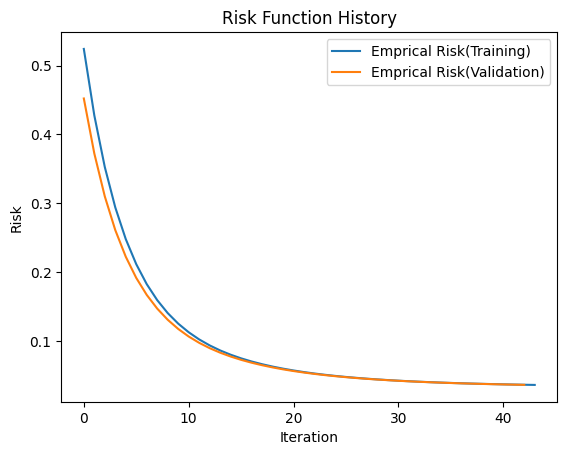

-0.0348*Id(X1) + 0.1976*Id(X2) + 0.3049*Id(X3) + 0.2092*Id(X4) + -0.2326*Id(X5) + 0.1868*Id(X6) + 0.1868 = y'
['p>0.05', 'p>0.05', 'p<0.001', 'p<0.001', 'p<0.001']


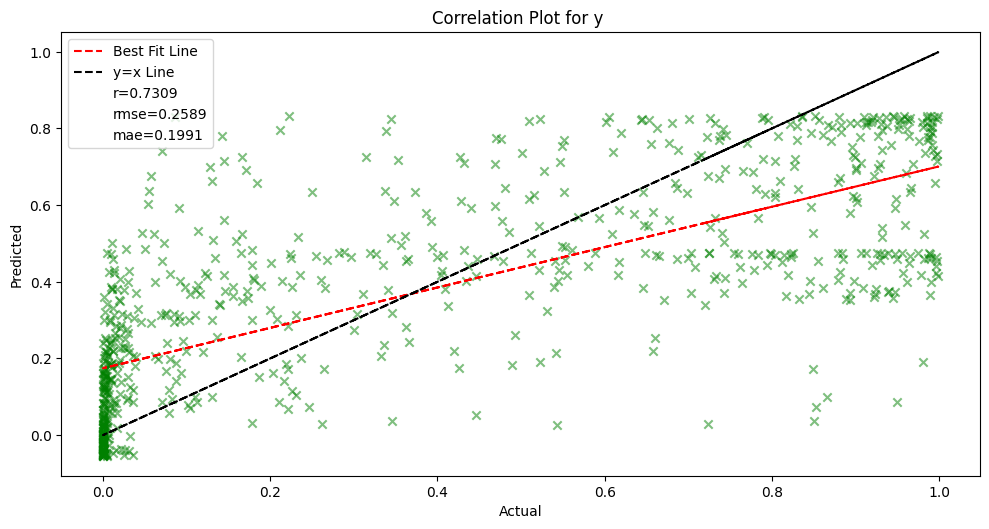

In [80]:
theta_gd_identity, train_losses, val_losses = grad_desc_sq_err(
    X_train, y_train, X_val, y_val, identity)
plot_train_loss(train_losses, val_losses)
print_poly(theta_gd_identity, "Id")
plot_y(X_test, y_test, theta_gd_identity, identity)

# theta_gd_identity_norm_2, train_losses, val_losses = grad_desc_sq_err(
#     X_train_norm_2, y_train_norm_2, X_val_norm_2, y_val_norm_2, identity)
# print_poly(theta_gd_identity_norm_2, "Id", "norm_2")
# plot_train_loss(train_losses, val_losses)
# plot_y(X_test_norm_2, y_test_norm_2, theta_gd_identity_norm_2, identity, "norm_2")

# theta_gd_identity_norm_zs, train_losses, val_losses = grad_desc_sq_err(
#     X_train_norm_zs, y_train_norm_zs, X_val_norm_zs, y_val_norm_zs, identity)
# plot_train_loss(train_losses, val_losses)
# print_poly(theta_gd_identity_norm_zs, "G", "norm_zs")
# plot_y(X_test_norm_zs, y_test_norm_zs, theta_gd_identity_norm_2, identity, "norm_zs")